# Response for Single Initial Element Workbook

This Jupyter Notebook is designed to enable comparisons for the neutron activation response of single element analyzed by an ALARA run across datasets. The purpose of this notebook is for the validation of ALARAJOY-processed data from the FENDL3.2x data sets.

**Import Packages**

In [1]:
import single_element as se
import importlib
from pathlib import Path
from numpy import logspace

**Run ALARA with each prepared binary data library**

In [47]:
importlib.reload(se)
data_source = {
    'fendl2' : '/groupspace/shared/n/nukecode/ALARA/data/fendl2bin',
    'fendl3' : '../examples/data/fendl3'
}

element = input('Select single parent element to evaluate: ').lower()

for libname, binary in data_source.items():
    alara_input = se.fill_alara_template(element, binary)
    se.write_alara_input_file(alara_input)
    output = f'{element}_{libname}.out'
    Path(output).unlink(missing_ok=True)
    se.run_alara(element, libname)
    data_source[libname] = output

**Convert ALARA output files to Pandas DataFrames**

In [48]:
dfs = se.process_metadata(data_source)

times = list(dfs['fendl2 Number Density']['Data'].columns[1:])

# Example DataFrame
dfs['fendl3 Number Density']['Data']

,isotope,shutdown,1e-05y,0.01y,1y,100y,10000y
0,h-1,1.170900e+22,1.170900e+22,1.170900e+22,1.170900e+22,1.170900e+22,1.170900e+22
1,h-2,2.823400e+20,2.823400e+20,2.823400e+20,2.823400e+20,2.823400e+20,2.823400e+20
2,h-3,1.620800e+17,1.620800e+17,1.619800e+17,1.532500e+17,5.979000e+14,0.000000e+00
3,he-3,1.086300e+16,1.086300e+16,1.095400e+16,1.969300e+16,1.723400e+17,1.729400e+17
4,he-4,2.652700e+21,2.652700e+21,2.652700e+21,2.652700e+21,2.652700e+21,2.652700e+21
...,...,...,...,...,...,...,...
219,fe-58r,1.241400e+18,1.241400e+18,1.241400e+18,1.241400e+18,1.241400e+18,1.241400e+18
220,fe-58s,1.627600e+18,1.627600e+18,1.627600e+18,1.627600e+18,1.627600e+18,1.627600e+18
221,fe-58t,4.993900e+17,4.993900e+17,4.993900e+17,4.993900e+17,4.993900e+17,4.993900e+17
222,fe-58u,1.755000e+18,1.755000e+18,1.755000e+18,1.755000e+18,1.755000e+18,1.755000e+18


**Plot for a Single Data Source**

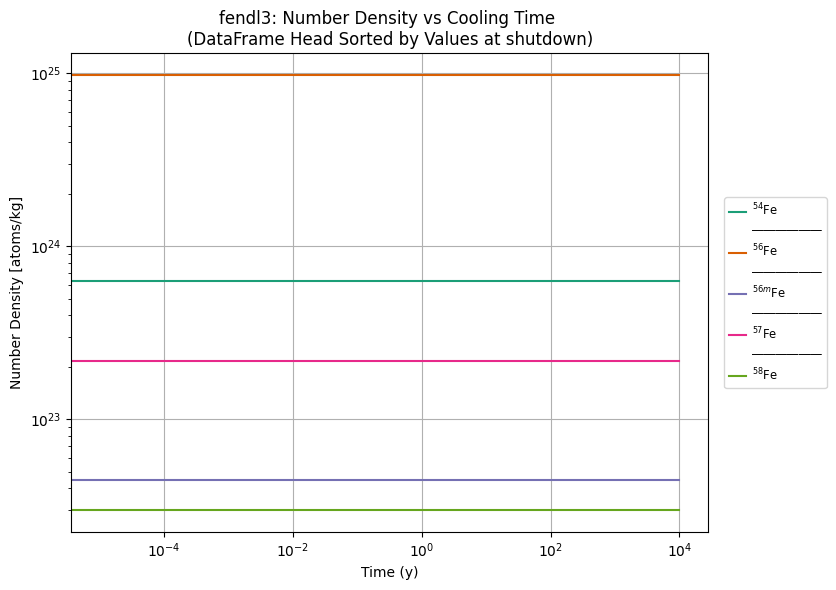

In [49]:
importlib.reload(se)
se.plot_single_nuc(
    dfs['fendl3 Number Density'],
    total=False,
    head=5,
    seconds=False
)

**Comparatively Plot Data for Two Data Sources**

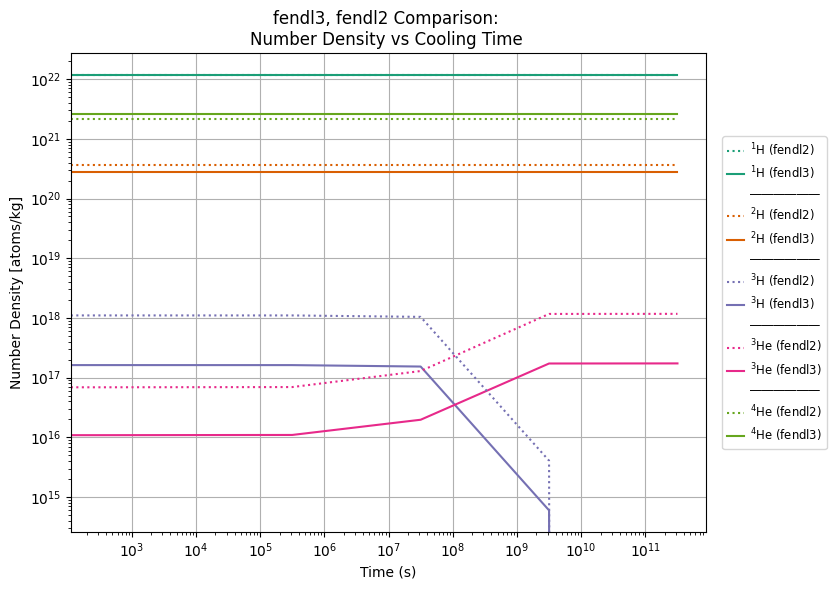

In [50]:
# Gas Production
importlib.reload(se)
variable = 'Number Density'
se.plot_single_nuc(
    [dfs[f'fendl3 {variable}'], dfs[f'fendl2 {variable}']],
    total=False, 
    element=['h', 'he'], 
#    sort_by_time='shutdown',
#    head=6
)

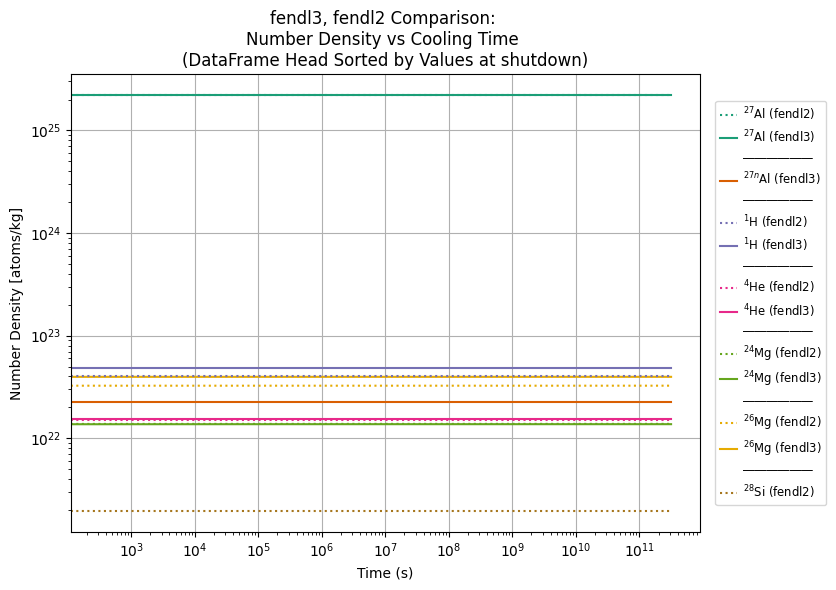

In [39]:
importlib.reload(se)
variable = 'Number Density'
se.plot_single_nuc(
    [dfs[f'fendl3 {variable}'], dfs[f'fendl2 {variable}']],
    total=False, 
    head=6
)

**Iteratively Compare Totals from Each Variable between the Data Sets**

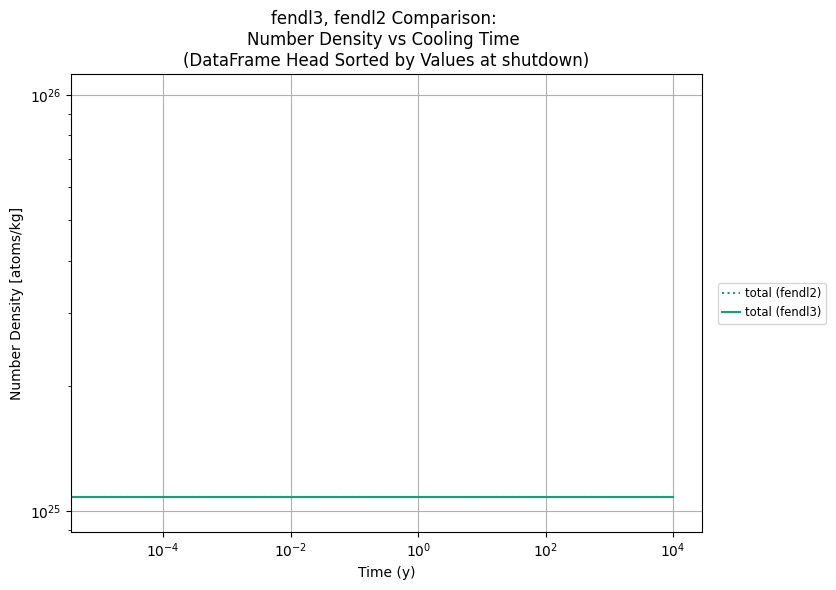

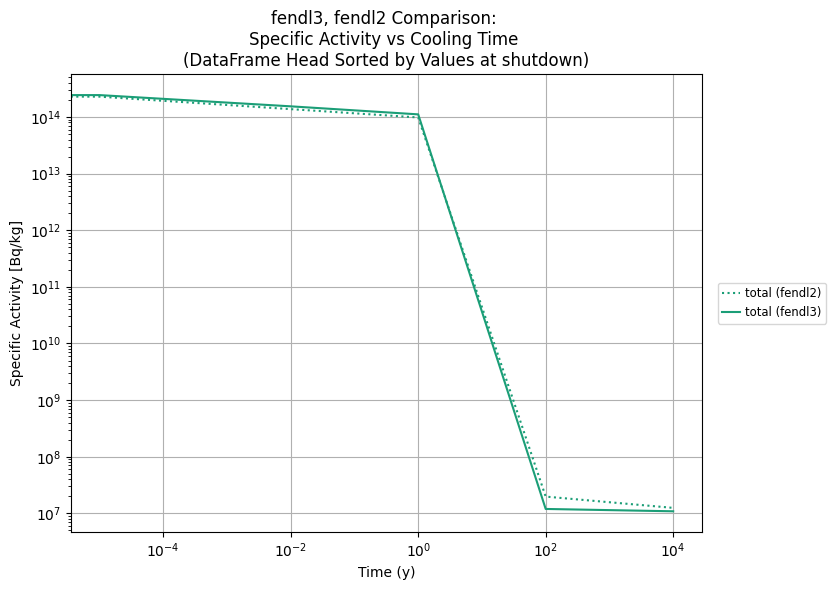

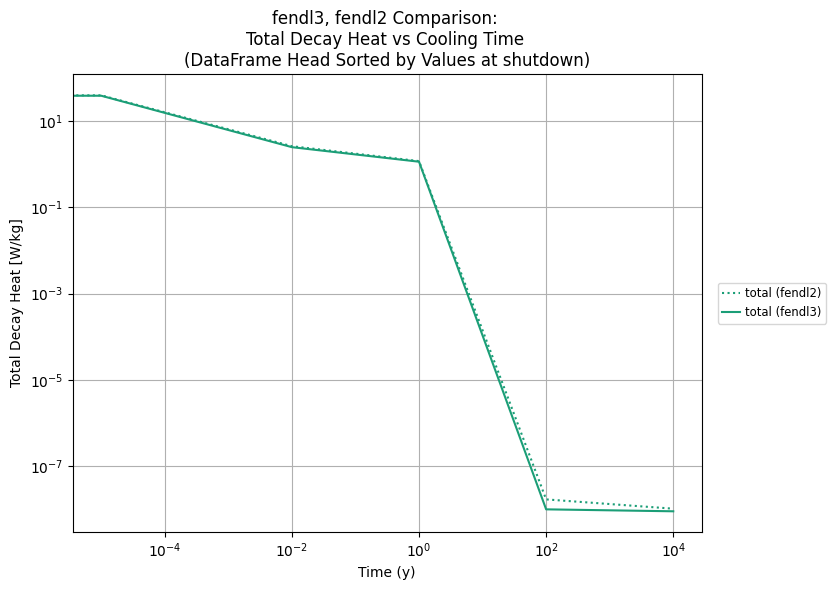

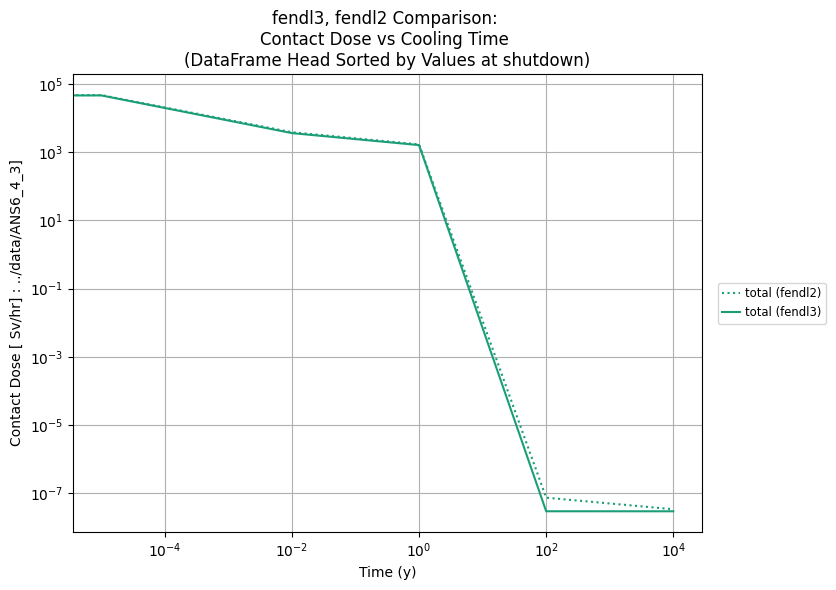

In [51]:
importlib.reload(se)
variables = [
    'Number Density', 'Specific Activity', 'Total Decay Heat', 'Contact Dose'
]
for variable in variables:
    se.plot_single_nuc(
        [dfs[f'fendl3 {variable}'], dfs[f'fendl2 {variable}']],
        total=True,
        head=1,
        seconds=False
    )

**Plot Pie charts for each Data Set at each Cooling Time, Variable**

In [ ]:
importlib.reload(se)
datalibs = ['fendl2', 'fendl3']
for datalib in datalibs:
    for variable in variables:
        for time in times:
            se.single_data_source_pie(dfs[f'{datalib} {variable}'], time)

**Extending Individual Pie Chart Data Over Time**

The plots below extend the pie charts from above to show the relative contributions of each variable over time.

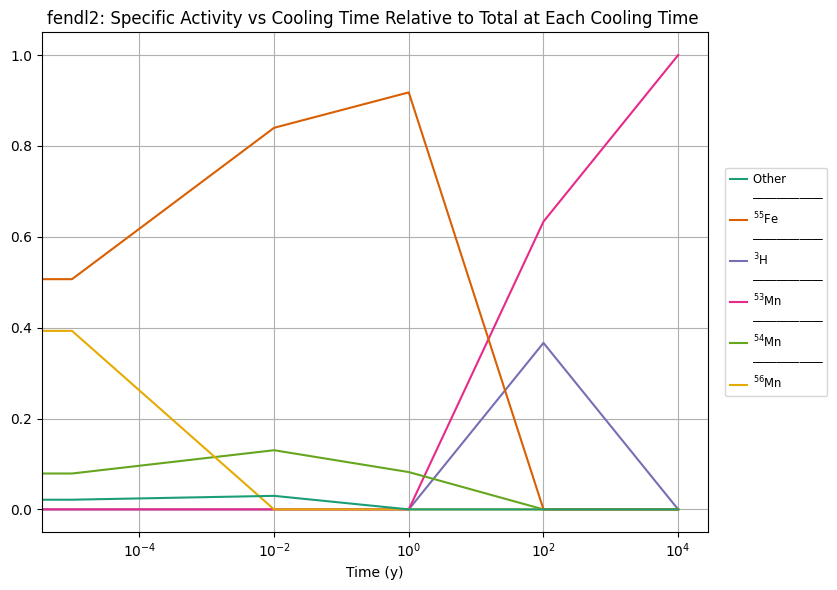

In [53]:
# Single Data Set
importlib.reload(se)
df2 = se.relative_contributions(dfs['fendl2 Specific Activity']['Data'])
df2 = se.process_metadata(
    df2,
    inp_datalib='fendl2',
    inp_variable='Specific Activity',
    inp_unit='Bq/kg'
    )

se.plot_single_nuc(
    df2['fendl2 Specific Activity'], 
    relative=True,
    filter_small=True,
    seconds=False,
    yscale='linear')

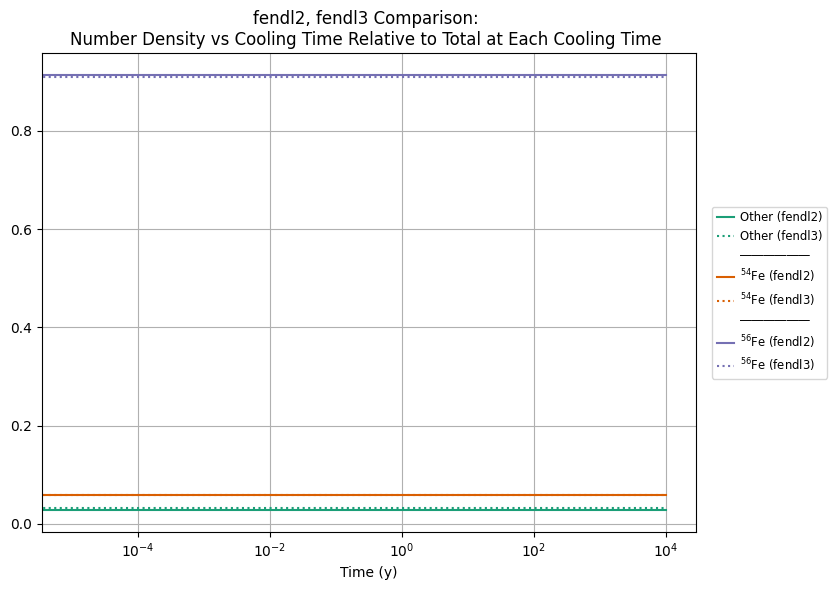

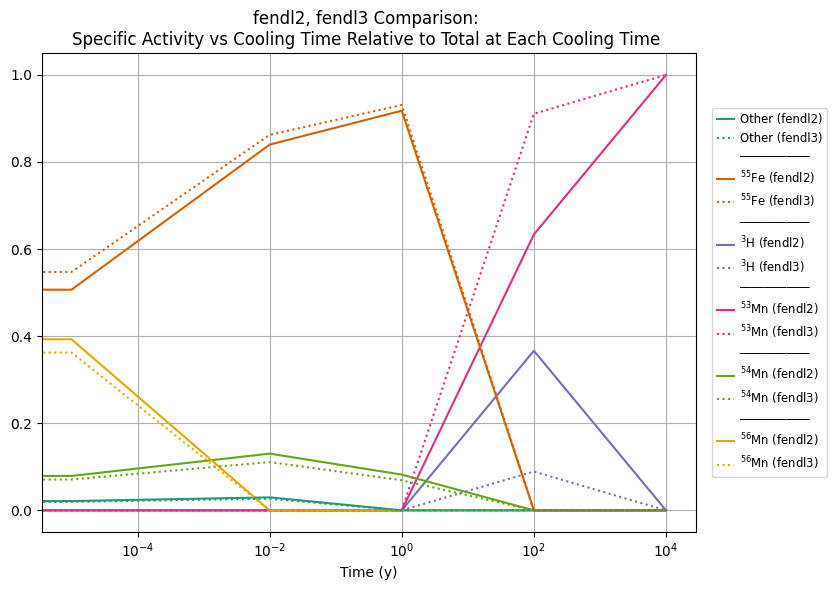

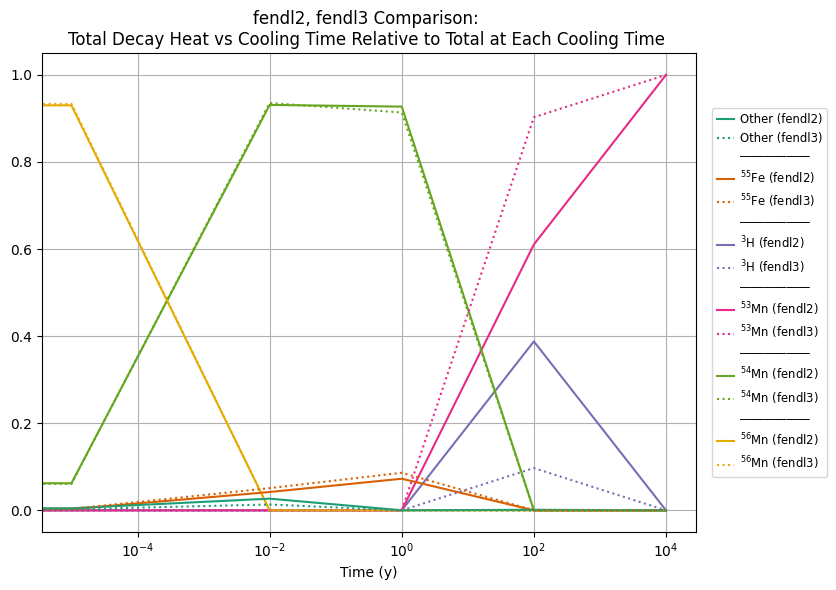

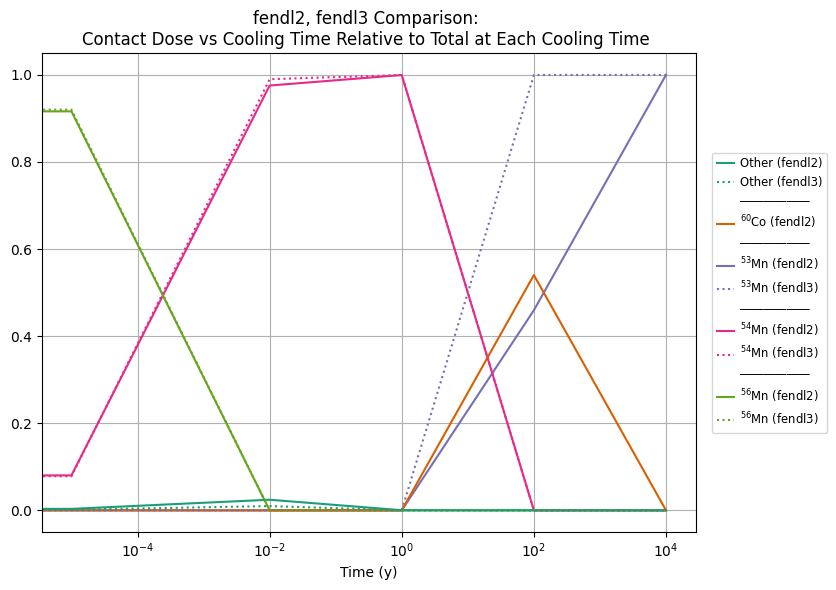

In [54]:
importlib.reload(se)
units = ['atoms/kg', 'Bq/kg', 'W/kg', 'Sv/hr']
datalibs = ['fendl2', 'fendl3']
for variable, unit in zip(variables, units):
    rel_dfs = []
    for datalib in datalibs:
        rel_df =se.relative_contributions(dfs[f'{datalib} {variable}']['Data'])
        rel_df = se.process_metadata(
            rel_df,
            inp_datalib=datalib,
            inp_variable=variable,
            inp_unit=units
            )
        rel_dfs.append(rel_df[f'{datalib} {variable}'])
        
        
    se.plot_single_nuc(
        rel_dfs,
        relative=True,
        filter_small=True,
        seconds=False,
        yscale='linear')

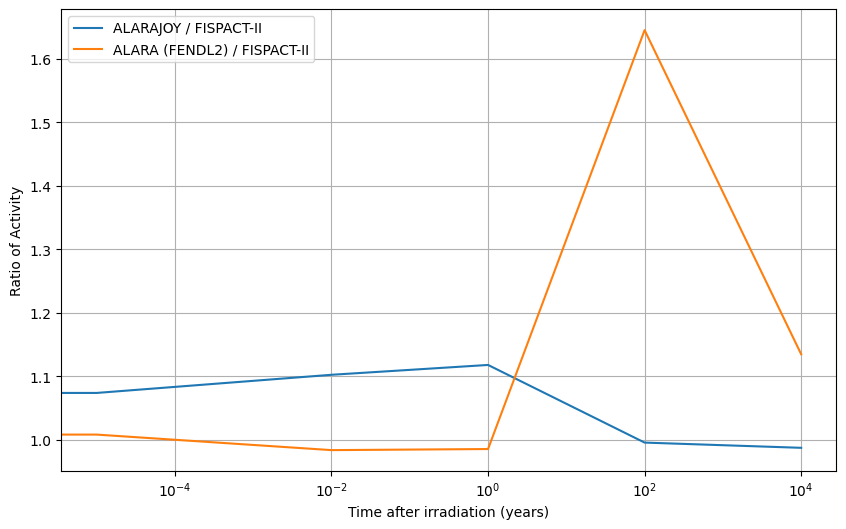

In [79]:
import matplotlib.pyplot as plt
from numpy import array
fispact = array([
    2.30e+14, 2.27e+14, 1.40e+14, 9.96e+13, 1.20e+07, 1.10e+07
])
_, fendl3 = se.separate_total(dfs['fendl3 Specific Activity']['Data'])
_, fendl2 = se.separate_total(dfs['fendl2 Specific Activity']['Data'])
times_y = se.process_time_vals(dfs['fendl3 Specific Activity']['Data'], seconds=False)
plt.figure(figsize=(10,6))
plt.plot(times_y, fendl3.values[0][1:] / fispact,
         label='ALARAJOY / FISPACT-II')
plt.plot(times_y, fendl2.values[0][1:] / fispact,
         label='ALARA (FENDL2) / FISPACT-II')
plt.xscale('log')
plt.grid()
plt.xlabel('Time after irradiation (years)')
plt.ylabel('Ratio of Activity')
plt.legend();

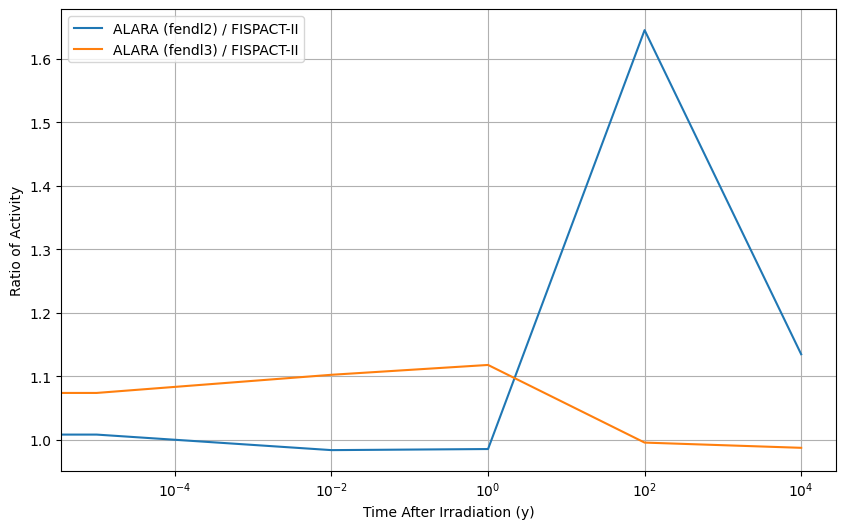

In [81]:
importlib.reload(se)
se.plot_fispact_comp(['fendl2', 'fendl3'], dfs, 'Specific Activity')

**Track Isotope and Cell-Level Differences between the DataFrames**

Create a new DataFrame comparing the difference isotopic contributions to the given ALARA output variable at each cooling time interval. Simultaneously, track which isotopes are represented only in one data set or the other to evaluate the significance of their absence to the other data set.

In [23]:
# Example using Number Density
importlib.reload(se)
diff, unique_isotopes = se.tabular_comp(dfs, 'Number Density')
unique_isotopes = se.maximum_contribution(
    dfs, 'Number Density', unique_isotopes
    )
unique_isotopes

{'fendl2': {'ta-182m': {'Absolute Number Density': {'Maximum Contribution': 3811500000000.0,
    'Time of Maximum Contribution': 'shutdown'},
   'Relative': {'Maximum Contribution': 1.1456266907123534e-12,
    'Time of Maximum Contribution': 'shutdown'}},
  'hf-177n': {'Absolute Number Density': {'Maximum Contribution': 153040000.0,
    'Time of Maximum Contribution': 'shutdown'},
   'Relative': {'Maximum Contribution': 4.5999398857829877e-17,
    'Time of Maximum Contribution': 'shutdown'}},
  'hf-182m': {'Absolute Number Density': {'Maximum Contribution': 1760800000000.0,
    'Time of Maximum Contribution': 'shutdown'},
   'Relative': {'Maximum Contribution': 5.292455665764954e-13,
    'Time of Maximum Contribution': 'shutdown'}},
  'ta-183': {'Absolute Number Density': {'Maximum Contribution': 4.0567e+18,
    'Time of Maximum Contribution': 'shutdown'},
   'Relative': {'Maximum Contribution': 1.219326720769462e-06,
    'Time of Maximum Contribution': 'shutdown'}},
  'ta-182': {'Abso

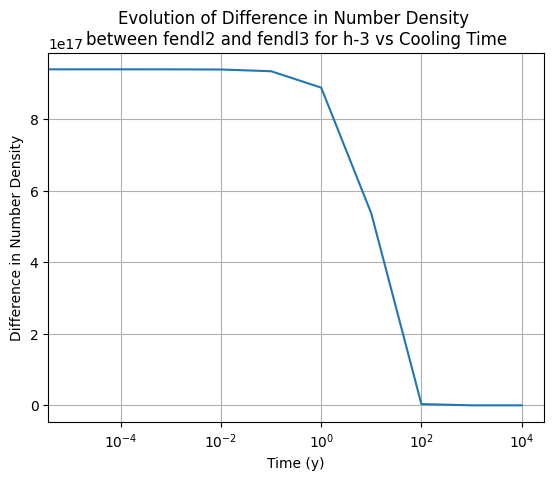

In [81]:
# Single isotope example

importlib.reload(se)

se.plot_isotope_diff(diff, 'h-3', 'Number Density', seconds=False)

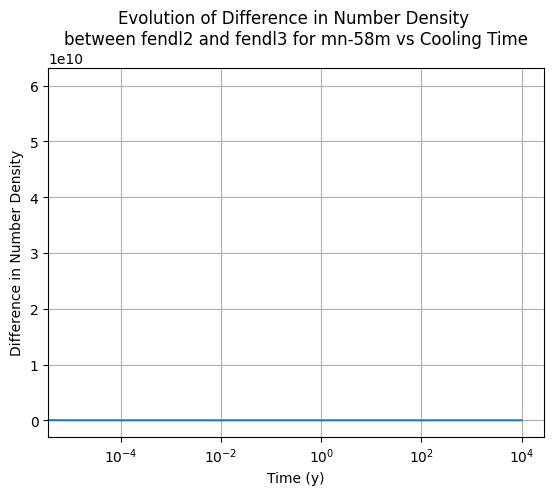

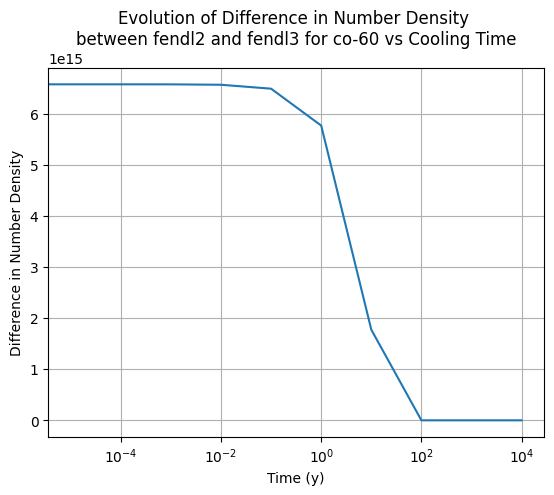

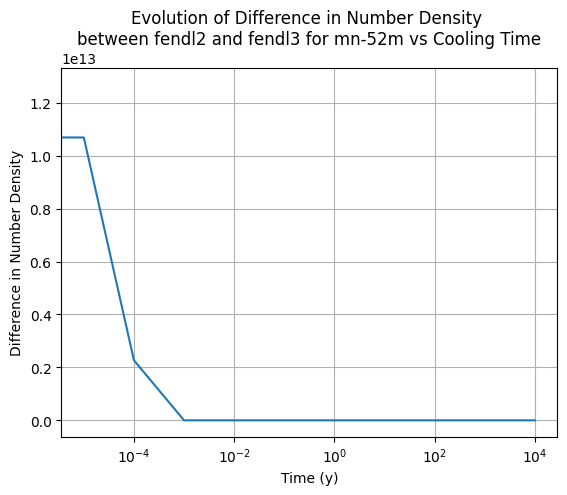

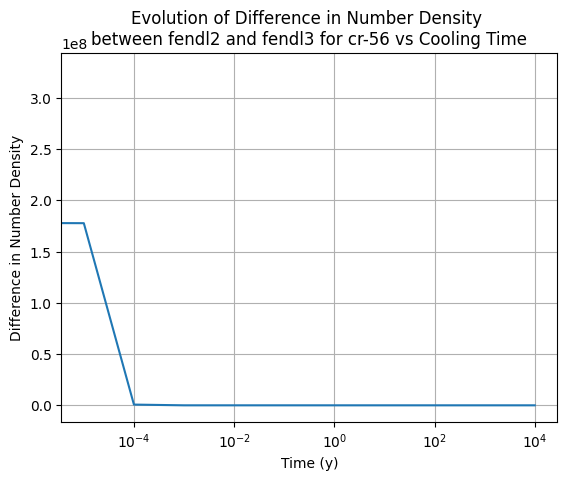

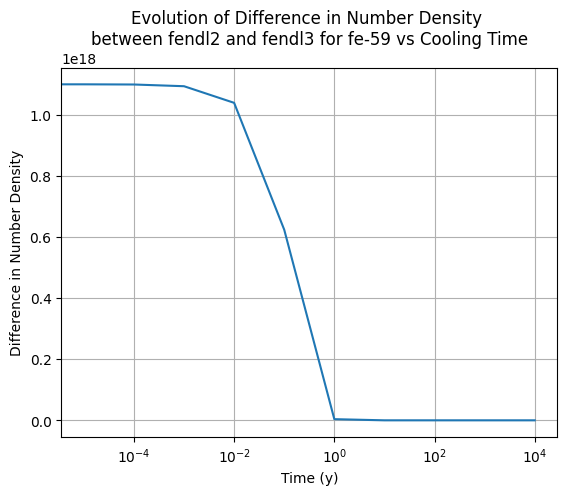

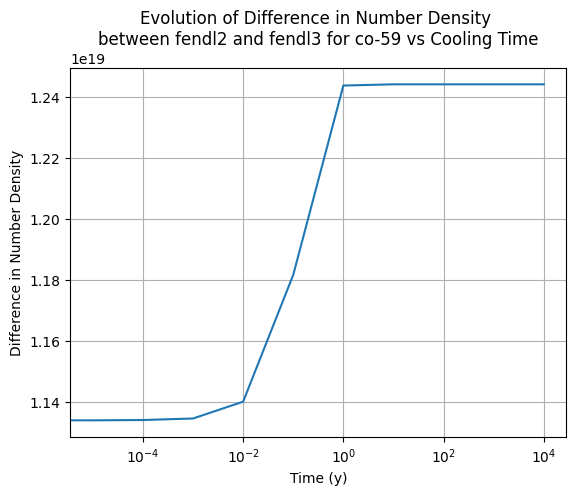

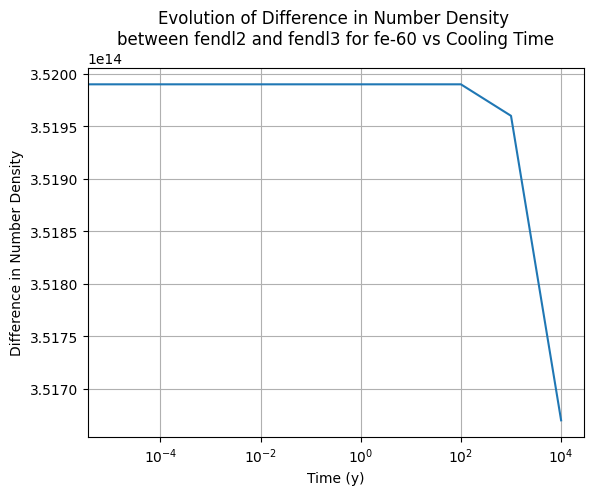

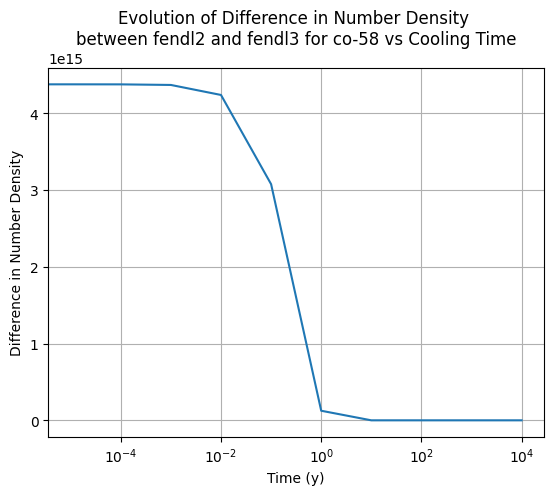

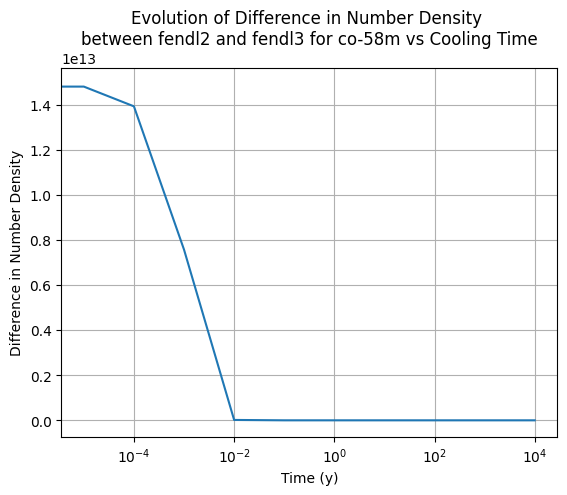

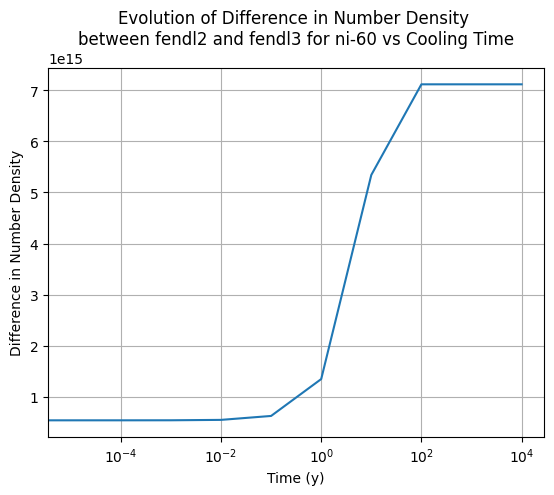

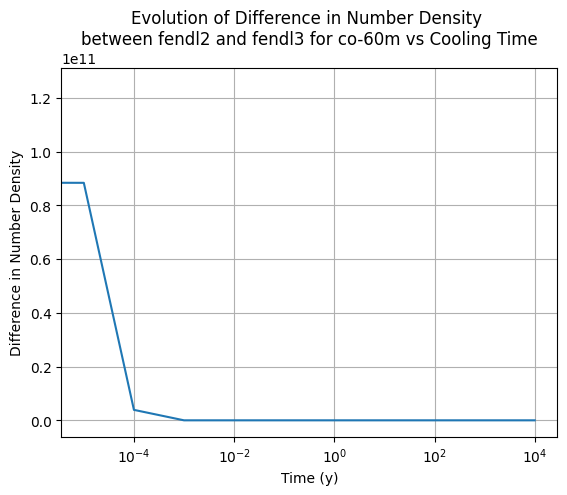

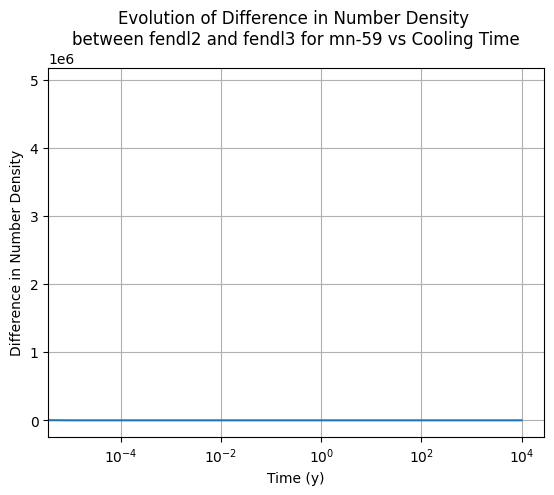

In [82]:
# All isotopes missing from 
for isotope in unique_isotopes['fendl2'].keys():
    se.plot_isotope_diff(diff, isotope, 'Number Density', seconds=False)